In [1]:
import torch
torch.__version__

'1.11.0+cu113'

In [2]:
try:
    # Check if PyTorch Geometric is installed:
    import torch_geometric
except ImportError:
    # If PyTorch Geometric is not installed, install it.
    %pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
    %pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0+cu113.html
    %pip install -q torch-geometric

     |████████████████████████████████| 7.9 MB 5.3 MB/s 
     |████████████████████████████████| 3.5 MB 5.5 MB/s 
     |████████████████████████████████| 407 kB 5.2 MB/s 


In [3]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch import nn
from torch.nn import Linear, LayerNorm
from torch_geometric.nn import GCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import Planetoid
import matplotlib.pyplot as plt
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.utils import accuracy
import numpy as np

## Dataset investigation

In [4]:
# Get some information about dataset

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
num_nodes = dataset.data.num_nodes
num_edges = dataset.data.num_edges // 2
train_len = dataset[0].train_mask.sum()
val_len = dataset[0].val_mask.sum()
test_len = dataset[0].test_mask.sum()
other_len = num_nodes - train_len - val_len - test_len
print(f"Dataset: {dataset.name}")
print(f"Num. nodes: {num_nodes} (train={train_len}, val={val_len}, test={test_len}, other={other_len})")
print(f"Num. edges: {num_edges}")
print(f"Num. node features: {dataset.num_node_features}")
print(f"Num. classes: {dataset.num_classes}")
print(f"Dataset len.: {dataset.len()}")

Dataset: Cora
Num. nodes: 2708 (train=140, val=500, test=1000, other=1068)
Num. edges: 5278
Num. node features: 1433
Num. classes: 7
Dataset len.: 1


Processing...
Done!


In [5]:
# How our nods look like
print(dataset[0].x.shape) # [No. Nodes x Features]

torch.Size([2708, 1433])


In [6]:
# Print some of the normalized word counts of the first datapoint
dataset[0].x[0][:50]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.1111, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [7]:
# How do the labels look like
dataset[0].y

tensor([3, 4, 4,  ..., 3, 3, 3])

In [15]:
# Example of the train mask
dataset[0].train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [8]:
# Example of the test mask
dataset[0].test_mask

tensor([False, False, False,  ...,  True,  True,  True])

In [16]:
# Example of the validation mask
dataset[0].val_mask

tensor([False, False, False,  ..., False, False, False])

## Graph Convolutional Network

In [19]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, hidden_dim=16, dropout_rate = 0.5):
        super().__init__()
        self.dropout1 = torch.nn.Dropout(dropout_rate)
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.dropout2 = torch.nn.Dropout(dropout_rate)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First layer
        x = self.dropout1(x)
        x = self.conv1(x, edge_index)
        x = self.relu(x)

        # Second layer
        x = self.dropout2(x)
        x = self.conv2(x, edge_index)
        #x = self.relu(x)

        return x

In [21]:
print("Graph Convolutional Network (GCN):")
GCN(dataset.num_node_features, dataset.num_classes, 64)

Graph Convolutional Network (GCN):


GCN(
  (dropout1): Dropout(p=0.5, inplace=False)
  (conv1): GCNConv(1433, 64)
  (relu): ReLU(inplace=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (conv2): GCNConv(64, 7)
)

## Training and Evaluation

In [11]:
def train_step(model, data, optimizer, loss_fn):
    model.train()
    optimizer.zero_grad()
    mask = data.train_mask

    logits = model(data)[mask]
    y = data.y[mask]
    loss = loss_fn(logits, y)

    preds = logits.argmax(dim=1)
    acc = accuracy(preds, y)

    loss.backward()
    optimizer.step()

    return loss.item(), acc


@torch.no_grad()
def eval_step(model, data, loss_fn, stage):
    model.eval()
    mask = getattr(data, f"{stage}_mask")

    logits = model(data)[mask]
    y = data.y[mask]
    loss = loss_fn(logits, y)

    preds = logits.argmax(dim=1)
    acc = accuracy(preds, y)
    
    return loss.item(), acc

In [12]:
def train(model, data, optimizer, loss_fn = torch.nn.CrossEntropyLoss(),
    max_epochs = 200, early_stopping = 10, print_interval = 20, verbose = True):
  
    history = {"loss": [], "val_loss": [], "acc": [], "val_acc": []}
    for epoch in range(max_epochs):
        loss, acc = train_step(model, data, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, data, loss_fn, "val")
        history["loss"].append(loss)
        history["acc"].append(acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        if epoch > early_stopping and val_loss > np.mean(history["val_loss"][-(early_stopping + 1) : -1]):
            if verbose:
                print("\nEarly stopping...")

            break

        if verbose and epoch % print_interval == 0:
            print(f"\nEpoch: {epoch}\n----------")
            print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
            print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")

    test_loss, test_acc = eval_step(model, data, loss_fn, "test")
    if verbose:
        print(f"\nEpoch: {epoch}\n----------")
        print(f"Train loss: {loss:.4f} | Train acc: {acc:.4f}")
        print(f"  Val loss: {val_loss:.4f} |   Val acc: {val_acc:.4f}")
        print(f" Test loss: {test_loss:.4f} |  Test acc: {test_acc:.4f}")

    return history

In [13]:
def plot_history(history, title, font_size = 14):
    plt.figure(figsize=(12, 4))

    plt.suptitle(title, fontsize=font_size)
    ax1 = plt.subplot(121)
    ax1.set_title("Loss")
    ax1.plot(history["loss"], label="train")
    ax1.plot(history["val_loss"], label="val")
    plt.xlabel("Epoch")
    ax1.legend()

    ax2 = plt.subplot(122)
    ax2.set_title("Accuracy")
    ax2.plot(history["acc"], label="train")
    ax2.plot(history["val_acc"], label="val")
    plt.xlabel("Epoch")
    ax2.legend()


Epoch: 0
----------
Train loss: 1.9450 | Train acc: 0.1500
  Val loss: 1.9408 |   Val acc: 0.3600

Epoch: 20
----------
Train loss: 1.5975 | Train acc: 0.7500
  Val loss: 1.7242 |   Val acc: 0.7700

Epoch: 40
----------
Train loss: 1.0704 | Train acc: 0.8286
  Val loss: 1.3318 |   Val acc: 0.8040

Epoch: 60
----------
Train loss: 0.7739 | Train acc: 0.8929
  Val loss: 1.0373 |   Val acc: 0.8100

Early stopping...

Epoch: 79
----------
Train loss: 0.5608 | Train acc: 0.9214
  Val loss: 0.9312 |   Val acc: 0.8000
 Test loss: 0.8899 |  Test acc: 0.8160


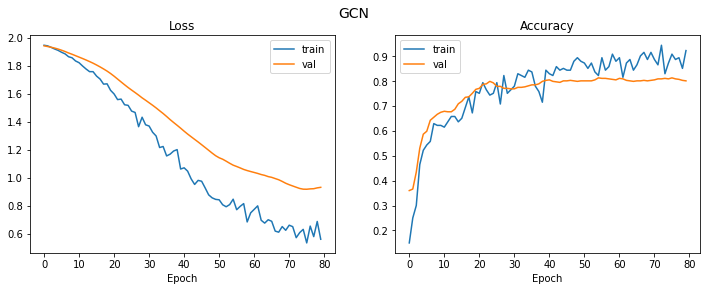

In [23]:
input_dim = dataset.num_features
HIDDEN_CHANNELS = 64
OUTPUT_DIM = 7
DROPOUT = 0.75
SEED = 42
MAX_EPOCHS = 200
LEARNING_RATE = 0.01
WEIGHT_DECAY = 5e-4
EARLY_STOPPING = 10

torch.manual_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = GCN(input_dim, OUTPUT_DIM, HIDDEN_CHANNELS, DROPOUT).to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
history = train(model, data, optimizer, max_epochs=MAX_EPOCHS, early_stopping=EARLY_STOPPING)

plot_history(history, "GCN")